# Standard Bond and Site Percolation Simulations
This examples illustrates how to set up an OpenPNM simulation to perform traditional bond and site percolation-type simulations. As usual, start by importing OpenPNM, the necessary model libraries and retrieving the controller object:

In [1]:
import scipy as sp
import openpnm as op
import matplotlib.pyplot as plt
%matplotlib inline
wrk = op.Workspace()
wrk.loglevel=50

C:\Users\Tom\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
[X, Y, Z] = [15, 15, 15]  # Network shape
pn = op.network.Cubic(shape=[X, Y, Z], spacing=1)

In this case it is necessary to create a Geometry object even though we don't need pore and throat sizes because physics are associated with a phase and a geometry which defines the locations of pores and throats where the physical models apply. In this simple case we use all the pores and throats. We also create a Phase object that will act as our conductor:

In [3]:
geom = op.geometry.GenericGeometry(network=pn, pores=pn.pores(), throats=pn.throats())
ionomer = op.phases.GenericPhase(network=pn)

In [4]:
phys = op.physics.GenericPhysics(network=pn, phase=ionomer, geometry=geom)
# Assign random numbers to throats
phys['throat.random_seed'] = sp.rand(pn.Nt,)
# Assign random numbers to pores
phys['pore.random_seed'] = sp.rand(pn.Np,)
phys['throat.ionic_conductance'] = 1.0

Finally, create an Algorithm object for performing the percolation calculations with the appropriate B.Cs:

In [5]:
Vin = 1.0
Vout = 0.0
Seff = op.algorithms.OhmicConduction(network=pn, phase=ionomer)
Seff.set_value_BC(pores=pn.pores('top'), values=Vin)
Seff.set_value_BC(pores=pn.pores('bottom'), values=Vout)
Seff.setup(tolerance=1e-5, conductance='throat.ionic_conductance')

For bond percolation, throats are progressively dropped from the Network and the overall Network conductivity is determined.  This is accomplished by running the Algorithm inside a loop, and by decreasing the number fraction of throat connections that conduct in the Network on each loop:

In [6]:
Sbond = []
# Create a list of number fractions to simulate
phis = sp.linspace(0.95, 0.01, 30).tolist()
for phi in phis:
    Ts = phys['throat.random_seed'] > phi
    phys['throat.ionic_conductance'][Ts] = 1.0e-5
    Seff._build_A(force=True)
    Seff._build_b(force=True)
    Seff.run()
    i = Seff.rate(pn.pores('top'))
    Sbond.append(float(i*Z/((Vin-Vout)*X*Y)))

To simulation site percolation, pores or sites are progressively removed as are all that pores neighboring throats. Again this is done insdie a loop:

In [7]:
phys['throat.ionic_conductance'] = 1.0
Ssite = []  # Create an empty list to store the effective conductivity results
for phi in phis:
    # Select a fraction of pores in the network
    Ps = phys['pore.random_seed'] > phi
    # Find the throats connected to pores
    Ts = pn.find_neighbor_throats(pores=pn.toindices(Ps))
    # Set non-conducting throats to low value
    phys['throat.ionic_conductance'][Ts] = 1.0e-5
    Seff._build_A(force=True)
    Seff._build_b(force=True)
    Seff.run()
    i = Seff.rate(pn.pores('bottom'))
    Ssite.append(float(i*Z/((Vin-Vout)*X*Y)))

The stored results can be visualized with Matplotlib on the same axes as the bond percolation results from above using

C:\Users\Tom\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


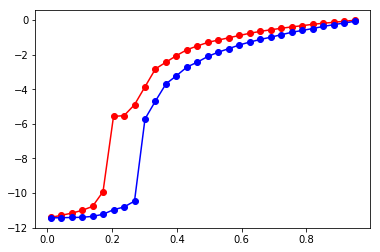

In [8]:
plt.figure()
plt.plot(phis, sp.log(Sbond), 'ro-')
plt.plot(phis, sp.log(Ssite), 'bo-')
plt.show()